In [1]:
# import Oracle_Assignment_2 as oa
# import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
# oa.q2_get_mnist_jpg_subset(23634)


In [2]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset



In [3]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),  # Convert to tensor
])


In [4]:



dataset = datasets.ImageFolder(root="q2_data", transform=transform)

# Split dataset into training and test sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:


def evaluate(model, train_loader, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    correct, total = 0, 0
    with torch.no_grad() :
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Train Accuracy: {100 * correct / total:.2f}%")


def train(model, train_loader, criterion, optimizer, device, epochs, test_loader):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  # Update weights using SGD with momentum

            total_loss += loss.item()

        # evaluate(model, train_loader, test_loader, device)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


def metricslearn(model, train_loader, test_loader, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


def dataloader_to_numpy(dataloader):
    data_list = []
    labels_list = []

    for images, labels in dataloader:
        images = images.numpy().reshape(images.shape[0], -1)
        data_list.append(images)
        labels_list.append(labels.numpy())

    data_array = np.vstack(data_list)
    labels_array = np.concatenate(labels_list)
    return data_array, labels_array

train_data, train_labels = dataloader_to_numpy(train_loader)
test_data, test_labels = dataloader_to_numpy(test_loader)


def pca(data, k) :
    cov_matrix = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]


    eigenvectors = eigenvectors[:, idx]
    eigenvalues = eigenvalues[idx]
    eigenvecks = eigenvectors[:, :k]
    new_data = np.dot(data, eigenvecks)
    return new_data, eigenvecks




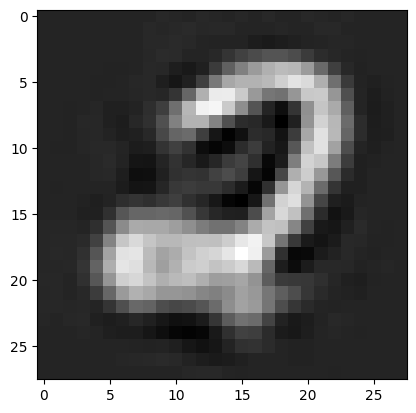

In [6]:


mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
k = 100
train_data_pca, eigenvecks = pca(train_data, k)
test_data_pca = np.dot(test_data, eigenvecks)



# Convert PCA-transformed data to tensors
train_data_pca_tensor = torch.tensor(train_data_pca, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_pca_tensor = torch.tensor(test_data_pca, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset and DataLoader
train_pca_dataset = TensorDataset(train_data_pca_tensor, train_labels_tensor)
test_pca_dataset = TensorDataset(test_data_pca_tensor, test_labels_tensor)

train_pca_loader = DataLoader(train_pca_dataset, batch_size=32, shuffle=True)
test_pca_loader = DataLoader(test_pca_dataset, batch_size=32, shuffle=False)

# Reconstruct a sample image
sample = train_data_pca[10]
reconstructed = np.dot(sample, eigenvecks.T)
reconstructed = (reconstructed * std) + mean
reconstructed = reconstructed.reshape(28, 28)
plt.imshow(reconstructed, cmap="gray")

 


In [7]:
from kan import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = KAN(width=[100,75,35,10],grid =5 ,k=3,seed=42,device=device).to(device)



checkpoint directory created: ./model
saving model version 0.0


In [8]:

len(train_pca_dataset)
for i in train_pca_dataset:
    print (i)
    break


# train(model,train_data_pca)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(model, train_pca_loader, criterion, optimizer, device, epochs=20, test_loader = test_pca_loader)



model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")




(tensor([ -1.1363, -10.1142,   3.1149,  -7.3692,  -4.9781,  -0.3431,   0.1415,
          0.2161,  -1.8036,  -2.6631,   1.9685,   0.9041,  -0.5736,   2.7548,
         -2.4869,   1.8764,  -0.1817,   2.6062,  -1.4688,   4.2357,   0.2727,
          2.8406,  -0.0665,  -3.8878,  -0.3576,   3.5008,   0.4086,   0.8712,
          1.2113,  -0.2676,  -0.9633,  -0.4784,   0.1877,  -0.4097,  -0.6399,
          1.9619,  -0.1484,  -0.2348,  -2.1437,  -1.6351,   1.0483,   0.6569,
         -1.2990,  -0.9371,  -1.3625,  -1.9442,  -0.7431,  -0.3556,   1.2343,
          0.4668,   1.1941,  -0.6166,  -0.3819,  -0.8315,   0.1817,   0.7214,
          1.4191,   1.4045,  -0.6565,  -1.1309,  -1.6980,  -0.6644,   1.0827,
         -2.1567,  -0.1445,   0.9523,   1.2380,   1.5561,   0.8930,  -1.2713,
         -2.8462,  -0.4108,   1.4259,   1.6058,   1.4215,   3.0007,  -2.4232,
         -0.6198,   1.3759,  -0.6399,  -2.2057,   0.0129,   0.7368,   0.2263,
         -0.1825,   0.6191,   0.0520,  -0.5391,   0.3354,   0.7

In [9]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 90.85%
Train Accuracy: 98.96%


In [13]:
count = 0

for p in model.parameters():
    if p.requires_grad:
      p_count = p.numel()
      count += p_count

print("Number of parameters for kan model =", count)
# print("The time taken to train for kan model =", end1-start1)

# count = 0

# for p in mlp_model.parameters():
#     if p.requires_grad:
#       p_count = p.numel()
#       count += p_count

# print("Number of parameters for mlp model =", count)
# print("The time taken to train for mlp model =", end2-start2)

Number of parameters for kan model = 146650
